In [42]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE

import torch
import torch.nn as nn

from train2 import to_np, device, group_left, group_right, get_dataset, AutoencodingWorldModel, collate_dataset

In [14]:
import itertools
import numpy as np

lang_4_2 = [''.join(i) for i in itertools.product('LR', repeat=4)]
lang_4_1 = []
for l in lang_4_2:
    if l[-1] == 'L':
        lang_4_1.append(l[:-1] + "A")
    else:
        lang_4_1.append(l[:-1] + "B")


lang_3_4 = [''.join(i) for i in itertools.product('LR', repeat=3)]
lang_3_321 = []
for l in lang_3_4:
    if l[-1] == 'L':
        c = "A"
    else:
        c = "B"
    lang_3_321.append(l[:-1] + c)
    lang_3_321.append(l[:-1] + c + "2")
    lang_3_321.append(l[:-1] + c + "3")
    
lang_2_2 = [''.join(i) for i in itertools.product('LR', repeat=2)]
lang_2_1 = []
for l in lang_2_2:
    if l[-1] == 'L':
        lang_2_1.append(l[:-1] + "A")
    else:
        lang_2_1.append(l[:-1] + "B")
        
        
lang_1 = ["L", "R"]
for c in ["A", "B"]:
    lang_1.append(c)
    lang_1.append(c + "2")
    lang_1.append(c + "3")


lang = np.concatenate([lang_4_2, lang_4_1, lang_3_4, lang_3_321, lang_2_2, lang_2_1, lang_1])
    

In [17]:
lang

array(['LLLL', 'LLLR', 'LLRL', 'LLRR', 'LRLL', 'LRLR', 'LRRL', 'LRRR',
       'RLLL', 'RLLR', 'RLRL', 'RLRR', 'RRLL', 'RRLR', 'RRRL', 'RRRR',
       'LLLA', 'LLLB', 'LLRA', 'LLRB', 'LRLA', 'LRLB', 'LRRA', 'LRRB',
       'RLLA', 'RLLB', 'RLRA', 'RLRB', 'RRLA', 'RRLB', 'RRRA', 'RRRB',
       'LLL', 'LLR', 'LRL', 'LRR', 'RLL', 'RLR', 'RRL', 'RRR', 'LLA',
       'LLA2', 'LLA3', 'LLB', 'LLB2', 'LLB3', 'LRA', 'LRA2', 'LRA3',
       'LRB', 'LRB2', 'LRB3', 'RLA', 'RLA2', 'RLA3', 'RLB', 'RLB2',
       'RLB3', 'RRA', 'RRA2', 'RRA3', 'RRB', 'RRB2', 'RRB3', 'LL', 'LR',
       'RL', 'RR', 'LA', 'LB', 'RA', 'RB', 'L', 'R', 'A', 'A2', 'A3', 'B',
       'B2', 'B3'], dtype='<U4')

In [18]:
''.join(lang)

'LLLLLLLRLLRLLLRRLRLLLRLRLRRLLRRRRLLLRLLRRLRLRLRRRRLLRRLRRRRLRRRRLLLALLLBLLRALLRBLRLALRLBLRRALRRBRLLARLLBRLRARLRBRRLARRLBRRRARRRBLLLLLRLRLLRRRLLRLRRRLRRRLLALLA2LLA3LLBLLB2LLB3LRALRA2LRA3LRBLRB2LRB3RLARLA2RLA3RLBRLB2RLB3RRARRA2RRA3RRBRRB2RRB3LLLRRLRRLALBRARBLRAA2A3BB2B3'

In [19]:
bit_rates = []
char_to_rate = {"L": 1, "R": 2, "A": 3, "B": 4, "2": 5, "3": 5}
for l in lang:
    bitrate = 0
    for c in l:
        bitrate += char_to_rate[c]
    bit_rates.append(bitrate)
    
print(bit_rates)        

[4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8, 6, 7, 7, 8, 7, 8, 8, 9, 7, 8, 8, 9, 8, 9, 9, 10, 3, 4, 4, 5, 4, 5, 5, 6, 5, 10, 10, 6, 11, 11, 6, 11, 11, 7, 12, 12, 6, 11, 11, 7, 12, 12, 7, 12, 12, 8, 13, 13, 2, 3, 3, 4, 4, 5, 5, 6, 1, 2, 3, 8, 8, 4, 9, 9]


In [24]:
action_sequences = []
char_to_rate = {"L": 1, "R": 2, "A": 3, "B": 4, "2": 5, "3": 5}
for l in lang:
    action_sequence = ''
    for c in l:
        if c == "L":
            action_sequence += '0000'
        elif c == "R":
            action_sequence += '1111'
        elif c == "A":
            action_sequence += '0'
        elif c == "B":
            action_sequence += '1'
        else:
            action_sequence += action_sequence[-1] * int(c)
            
    action_sequences.append(action_sequence)
print(action_sequences)

['0000000000000000', '0000000000001111', '0000000011110000', '0000000011111111', '0000111100000000', '0000111100001111', '0000111111110000', '0000111111111111', '1111000000000000', '1111000000001111', '1111000011110000', '1111000011111111', '1111111100000000', '1111111100001111', '1111111111110000', '1111111111111111', '0000000000000', '0000000000001', '0000000011110', '0000000011111', '0000111100000', '0000111100001', '0000111111110', '0000111111111', '1111000000000', '1111000000001', '1111000011110', '1111000011111', '1111111100000', '1111111100001', '1111111111110', '1111111111111', '000000000000', '000000001111', '000011110000', '000011111111', '111100000000', '111100001111', '111111110000', '111111111111', '000000000', '00000000000', '000000000000', '000000001', '00000000111', '000000001111', '000011110', '00001111000', '000011110000', '000011111', '00001111111', '000011111111', '111100000', '11110000000', '111100000000', '111100001', '11110000111', '111100001111', '111111110', '1

In [31]:
def lz78_compress(data):
    compressed = []
    dictionary = {}
    current_string = ""

    for char in data:
        current_string += char

        if current_string not in dictionary:
            # Add the current string to the dictionary
            index = len(dictionary) + 1
            dictionary[current_string] = index

            # Output the dictionary index and the character
            compressed.append((dictionary.get(current_string[:-1], 0), char))

            # Reset the current string
            current_string = ""

    return compressed


def lz78_decompress(compressed):
    decompressed = []
    dictionary = {}

    for index, char in compressed:
        if index == 0:
            # Zero index, just add the character
            substring = char
        else:
            # Reconstruct the substring from the dictionary
            substring = dictionary[index] + char

        decompressed.append(substring)

        # Update the dictionary
        dictionary[len(dictionary) + 1] = substring

    return ''.join(decompressed)

# data = "The quick brown fox jumps over the lazy dog. The quick brown dog jumps over the lazy fox."
data = '\n'.join(action_sequences)
compressed_data = lz78_compress(data)
decompressed_data = lz78_decompress(compressed_data)

print("Original data:", data)
print("Compressed data:", compressed_data)
# print("Decompressed data:", decompressed_data)

Original data: 0000000000000000
0000000000001111
0000000011110000
0000000011111111
0000111100000000
0000111100001111
0000111111110000
0000111111111111
1111000000000000
1111000000001111
1111000011110000
1111000011111111
1111111100000000
1111111100001111
1111111111110000
1111111111111111
0000000000000
0000000000001
0000000011110
0000000011111
0000111100000
0000111100001
0000111111110
0000111111111
1111000000000
1111000000001
1111000011110
1111000011111
1111111100000
1111111100001
1111111111110
1111111111111
000000000000
000000001111
000011110000
000011111111
111100000000
111100001111
111111110000
111111111111
000000000
00000000000
000000000000
000000001
00000000111
000000001111
000011110
00001111000
000011110000
000011111
00001111111
000011111111
111100000
11110000000
111100000000
111100001
11110000111
111100001111
111111110
11111111000
111111110000
111111111
11111111111
111111111111
00000000
00001111
11110000
11111111
00000
00001
11110
11111
0000
1111
0
000
0000
1
111
1111
Compressed da

In [41]:
def printRLE(st):
    rle= []
    n = len(st)
    i = 0
    while i < n- 1:
 
        # Count occurrences of 
        # current character
        count = 1
        while (i < n - 1 and
               st[i] == st[i + 1]):
            count += 1
            i += 1
        i += 1
 
        # Print character and its count
        rle.append(st[i - 1] + str(count))
    return rle

 
st = "".join(action_sequences)
new_st = ["L" if c == "0" else "R" for c in st]
np.unique(printRLE(new_st))

array(['L1', 'L12', 'L20', 'L25', 'L28', 'L3', 'L4', 'L40', 'L5', 'L7',
       'L8', 'L9', 'R1', 'R12', 'R13', 'R16', 'R3', 'R32', 'R4', 'R5',
       'R7', 'R8'], dtype='<U3')

In [23]:
ascii_lowercase = 'abcdefghijklmnopqrstuvwxyz'
ascii_uppercase = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
digits = '0123456789'
punc = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'

data = ascii_lowercase + ascii_uppercase + digits + punc
data[:80]

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&()*+,-./:;<='

In [20]:
np.average(bit_rates)

7.15

In [ ]:
lang_4_2 = [''.join(i) for i in itertools.product('LR', repeat=4)]
lang_4_1 = []
for l in lang_4_2:
    if l[-1] == 'L':
        lang_4_1.append(l[:-1] + "A")
    else:
        lang_4_1.append(l[:-1] + "B")


lang_3_4 = [''.join(i) for i in itertools.product('LR', repeat=3)]
lang_3_321 = []
for l in lang_3_4:
    if l[-1] == 'L':
        c = "A"
    else:
        c = "B"
    lang_3_321.append(l[:-1] + c)
    lang_3_321.append(l[:-1] + c + "2")
    lang_3_321.append(l[:-1] + c + "3")
    
lang_2_2 = [''.join(i) for i in itertools.product('LR', repeat=2)]
lang_2_1 = []
for l in lang_2_2:
    if l[-1] == 'L':
        lang_2_1.append(l[:-1] + "A")
    else:
        lang_2_1.append(l[:-1] + "B")
        
        
lang_1 = ["L", "R"]
for c in ["A", "B"]:
    lang_1.append(c)
    lang_1.append(c + "2")
    lang_1.append(c + "3")


lang = np.concatenate([lang_4_2, lang_4_1, lang_3_4, lang_3_321, lang_2_2, lang_2_1, lang_1])

80

In [43]:
train_dataset, test_dataset = get_dataset()
train_data = collate_dataset(train_dataset)
test_data = collate_dataset(test_dataset)
world_model = AutoencodingWorldModel(.001, 8, .01, .0).to(device)
world_model.load_state_dict(torch.load(f"data/models/{world_model.model_name}.ckpt"))

<All keys matched successfully>

In [44]:
world_model

AutoencodingWorldModel(
  (state_encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 5), stride=(1, 1))
    (1): SiLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): SiLU()
  )
  (state_encoder2): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 5), stride=(1, 1))
    (1): SiLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): SiLU()
  )
  (transition_model): Sequential(
    (0): Linear(in_features=9, out_features=16, bias=True)
    (1): SiLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): SiLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): SiLU()
  )
  (state_decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 5), stride=(1, 1))
    (1): SiLU()
    (2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
  )
)

In [45]:
state_rep = world_model.get_state_encoding(train_data[0])

In [46]:
state_rep[::2]

tensor([[ 0.6137, -0.1550, -0.0591, -0.1374, -0.0929,  0.1557, -0.1741,  1.8393],
        [-0.2579, -0.2208, -0.2031, -0.2020, -0.2781,  2.1024,  0.3031,  0.0235],
        [ 0.6365, -0.1621, -0.0538, -0.1548, -0.0939,  0.1153, -0.1717,  1.8457],
        [-0.2620, -0.2282, -0.1970, -0.2046, -0.2782,  2.0496,  0.2322,  0.0261],
        [ 0.5948, -0.1483, -0.0616, -0.1314, -0.0897,  0.1685, -0.1647,  1.8361],
        [-0.2609, -0.2278, -0.1947, -0.2211, -0.2768,  2.1379,  0.3580,  0.0032]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [47]:
results = world_model(train_data[0], train_data[1])

In [48]:
results['next_state_encoding']

tensor([[-0.0431,  1.1576,  1.7891,  0.6307, -0.2093, -0.2505, -0.2056, -0.2478],
        [ 0.9218, -0.2447, -0.2151, -0.2581,  0.3139,  0.5567,  0.5780,  0.1046],
        [-0.0223,  1.2940,  1.8652,  0.4713, -0.2084, -0.2744, -0.1818, -0.1687],
        [-0.1769, -0.1093,  0.0320, -0.1566,  0.2063,  0.2662,  0.0186, -0.2228],
        [-0.0432,  1.1565,  1.7891,  0.6325, -0.2096, -0.2490, -0.2057, -0.2488],
        [ 0.9265, -0.2454, -0.2158, -0.2583,  0.3135,  0.5572,  0.5783,  0.1062],
        [-0.0222,  1.2951,  1.8667,  0.4695, -0.2089, -0.2742, -0.1812, -0.1680],
        [-0.1795, -0.1092,  0.0343, -0.1560,  0.2055,  0.2654,  0.0154, -0.2237],
        [-0.0432,  1.1571,  1.7876,  0.6300, -0.2090, -0.2510, -0.2059, -0.2477],
        [ 0.9199, -0.2443, -0.2148, -0.2581,  0.3138,  0.5548,  0.5783,  0.1051],
        [-0.0222,  1.2965,  1.8669,  0.4717, -0.2082, -0.2744, -0.1818, -0.1685],
        [-0.1796, -0.1079,  0.0335, -0.1559,  0.2057,  0.2655,  0.0171, -0.2237]],
       device='

In [49]:
for x, y in zip(results['next_state_encoding'][group_left], results['next_state_encoding'][group_right]):
    print(x)
    print(y)
    print()
    
with torch.no_grad():
    print(nn.functional.mse_loss(results['next_state_encoding'][group_left], results['next_state_encoding'][group_right]))
    print(nn.functional.mse_loss(results['next_state'][group_left], train_data[2]))

tensor([-0.0431,  1.1576,  1.7891,  0.6307, -0.2093, -0.2505, -0.2056, -0.2478],
       device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([-0.0432,  1.1565,  1.7891,  0.6325, -0.2096, -0.2490, -0.2057, -0.2488],
       device='cuda:0', grad_fn=<UnbindBackward0>)

tensor([-0.0431,  1.1576,  1.7891,  0.6307, -0.2093, -0.2505, -0.2056, -0.2478],
       device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([-0.0432,  1.1571,  1.7876,  0.6300, -0.2090, -0.2510, -0.2059, -0.2477],
       device='cuda:0', grad_fn=<UnbindBackward0>)

tensor([-0.0432,  1.1565,  1.7891,  0.6325, -0.2096, -0.2490, -0.2057, -0.2488],
       device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([-0.0432,  1.1571,  1.7876,  0.6300, -0.2090, -0.2510, -0.2059, -0.2477],
       device='cuda:0', grad_fn=<UnbindBackward0>)

tensor([ 0.9218, -0.2447, -0.2151, -0.2581,  0.3139,  0.5567,  0.5780,  0.1046],
       device='cuda:0', grad_fn=<UnbindBackward0>)
tensor([ 0.9265, -0.2454, -0.2158, -0.2583,  0.3135,  0.5572,  0.5783,  0

In [50]:
train_results = world_model(train_data[0], train_data[1])
test_results = world_model(test_data[0], test_data[1])
pred_next_states = torch.cat((train_results["next_state"], test_results["next_state"]), dim=0)
pred_states = torch.cat((train_results["state"], test_results["state"]), dim=0)
pred_next_state_encodings = torch.cat((train_results["next_state_encoding"], test_results["next_state_encoding"]), dim=0)

In [51]:
state_tensors = torch.cat((train_data[0], test_data[0]))
action_tensors = torch.cat((train_data[1], test_data[1]))
next_state_tensors = torch.cat((train_data[2], test_data[2]))

In [52]:
old_state_encoder2 = copy.deepcopy(world_model.state_encoder2)
world_model.state_encoder2 = new_state_encoder
new_train_results = world_model(train_data[0], train_data[1])
new_test_results = world_model(test_data[0], test_data[1])
new_pred_next_states = torch.cat((new_train_results["next_state"], new_test_results["next_state"]), dim=0)
new_pred_states = torch.cat((new_train_results["state"], new_test_results["state"]), dim=0)
new_pred_next_state_encodings = torch.cat((new_train_results["next_state_encoding"], new_test_results["next_state_encoding"]), dim=0)
world_model.state_encoder2 = old_state_encoder2

NameError: name 'new_state_encoder' is not defined

In [108]:
with torch.no_grad():
    print(nn.functional.mse_loss(pred_next_states, new_pred_next_states))
    print(nn.functional.mse_loss(pred_states, new_pred_states))


tensor(0.0020, device='cuda:0')
tensor(0.0011, device='cuda:0')


In [53]:
def plot_predicted_transitions():
    def plot_pred_transition(ax_row, state, action, next_state, pred_next_state):
        ax_row[0].imshow(state.transpose((1, 2, 0)) * 255)
        ax_row[0].set_title(f"Action: {action}")
        ax_row[1].imshow(next_state.transpose((1, 2, 0)) * 255)
        ax_row[2].imshow(np.clip(to_np(pred_next_state) * 255, 0, 255).astype(int).transpose((1, 2, 0)))
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    dataset = train_dataset + test_dataset
    n_state_action_pairs = len(dataset)
    fig, axes = plt.subplots(n_state_action_pairs, 3, figsize=(3, 12))
    for i in range(n_state_action_pairs):
        state, action, next_state = dataset[i]
        plot_pred_transition(axes[i], state, action, next_state, pred_next_states[i])
    plt.show()
    
    
def plot_predicted_new_transitions():
    def plot_pred_transition(ax_row, state, action, next_state, pred_next_state, new_pred_next_state):
        ax_row[0].imshow(state.transpose((1, 2, 0)) * 255)
        ax_row[0].set_title(f"Action: {action}")
        ax_row[1].imshow(next_state.transpose((1, 2, 0)) * 255)
        ax_row[2].imshow(np.clip(to_np(pred_next_state) * 255, 0, 255).astype(int).transpose((1, 2, 0)))
        ax_row[3].imshow(np.clip(to_np(new_pred_next_state) * 255, 0, 255).astype(int).transpose((1, 2, 0)))
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    dataset = train_dataset + test_dataset
    n_state_action_pairs = len(dataset)
    fig, axes = plt.subplots(n_state_action_pairs, 4, figsize=(4, 12))
    for i in range(n_state_action_pairs):
        state, action, next_state = dataset[i]
        plot_pred_transition(axes[i], state, action, next_state, pred_next_states[i], new_pred_next_states[i])
        with torch.no_grad():
            print(nn.functional.mse_loss(pred_next_states[i], new_pred_next_states[i]).item())
    plt.show()

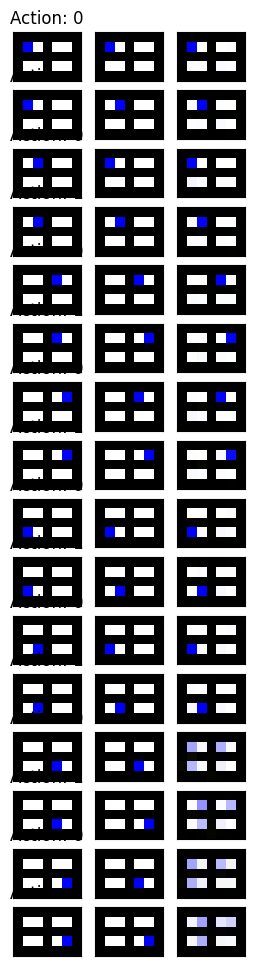

In [54]:
plot_predicted_transitions()

1.0960559848172124e-05
1.29565914903651e-05
1.046907709678635e-05
7.2831089710234664e-06
2.0284374841139652e-05
2.1782712792628445e-05
3.243495666538365e-05
2.549183955125045e-05
5.4425563575932756e-05
0.000278989493381232
3.952815313823521e-05
2.6616982722771354e-05
0.0045551578514277935
0.019754445180296898
0.0018118084408342838
0.005290661007165909


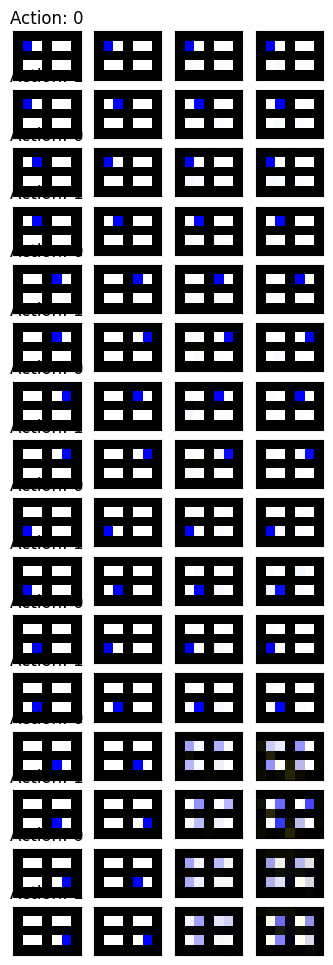

In [109]:
plot_predicted_new_transitions()

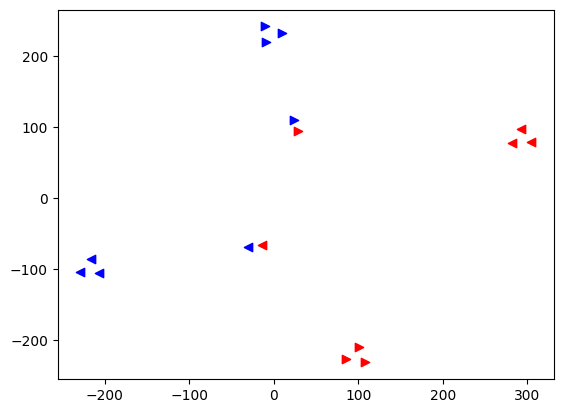

In [64]:
def plot_representations(next_state_encodings):
    next_state_representations = to_np(next_state_encodings)
    next_state_representations = TSNE(perplexity=2).fit_transform(next_state_representations)
    # colors = ["red", "blue", "black", "green"]
    colors = ["red", "blue"]
    markers = ["<", ">"]
    for s in range(8):
    # for s in range(6):
        for a in range(2):
            i = np.ravel_multi_index((s, a), (8, 2))
            c = colors[(i//2) % 2]
            m = markers[a]
            plt.scatter(next_state_representations[i, 0], next_state_representations[i, 1], c=c, marker=m)
    plt.show()
    
# plot_representations(pred_next_state_encodings[:-4])
plot_representations(pred_next_state_encodings)

In [58]:
with np.printoptions(precision=2):
    for i in range(4):
        print(to_np(pred_next_state_encodings)[i::4])
        print()

[[-0.04  1.16  1.79  0.63 -0.21 -0.25 -0.21 -0.25]
 [-0.04  1.16  1.79  0.63 -0.21 -0.25 -0.21 -0.25]
 [-0.04  1.16  1.79  0.63 -0.21 -0.25 -0.21 -0.25]
 [-0.03  1.21  1.83  0.57 -0.21 -0.28 -0.19 -0.21]]

[[ 0.92 -0.24 -0.22 -0.26  0.31  0.56  0.58  0.1 ]
 [ 0.93 -0.25 -0.22 -0.26  0.31  0.56  0.58  0.11]
 [ 0.92 -0.24 -0.21 -0.26  0.31  0.55  0.58  0.11]
 [ 0.46 -0.21 -0.14 -0.23  0.28  0.42  0.36 -0.04]]

[[-0.02  1.29  1.87  0.47 -0.21 -0.27 -0.18 -0.17]
 [-0.02  1.3   1.87  0.47 -0.21 -0.27 -0.18 -0.17]
 [-0.02  1.3   1.87  0.47 -0.21 -0.27 -0.18 -0.17]
 [-0.03  1.22  1.83  0.54 -0.21 -0.28 -0.19 -0.2 ]]

[[-0.18 -0.11  0.03 -0.16  0.21  0.27  0.02 -0.22]
 [-0.18 -0.11  0.03 -0.16  0.21  0.27  0.02 -0.22]
 [-0.18 -0.11  0.03 -0.16  0.21  0.27  0.02 -0.22]
 [ 0.25 -0.19 -0.1  -0.21  0.27  0.37  0.26 -0.1 ]]



In [60]:
to_np(pred_next_state_encodings).shape

(16, 8)

In [84]:
def train_state_encoder(n_minibatches):
    import copy
    new_state_encoder = copy.deepcopy(world_model.state_encoder2)
    
    with torch.no_grad():
        target_state_encodings = world_model.state_encoder2(state_tensors[:-4]).squeeze(-1).squeeze(-1)
    
    print(target_state_encodings[0])
    
    opt = torch.optim.Adam(new_state_encoder.parameters(), lr=0.001)
    recon_losses, rep_shift_penalties, losses = [], [], []
    
    for i in range(n_minibatches):
        state_encodings = new_state_encoder(state_tensors).squeeze(-1).squeeze(-1)
        if i == 0:
            print(state_encodings)
        recon_state = world_model.state_decoder(torch.cat((torch.zeros_like(state_encodings), state_encodings), dim=-1).unsqueeze(-1).unsqueeze(-1))
        recon_loss = nn.functional.mse_loss(recon_state, state_tensors)
        # rep_shift_penalty = nn.functional.mse_loss(state_encodings[:-4], target_state_encodings)
        rep_shift_penalty = torch.tensor(0)
        if i == 0:
            print(state_encodings[0])
            print(target_state_encodings[0])
        loss = recon_loss + rep_shift_penalty
        
        recon_losses.append(recon_loss.item())
        rep_shift_penalties.append(rep_shift_penalty.item())
        losses.append(loss.item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    plt.plot(range(n_minibatches), recon_losses, label="recon")
    plt.plot(range(n_minibatches), rep_shift_penalties, label="rep")
    plt.plot(range(n_minibatches), losses, label="losses")
    plt.legend()
    plt.show()
        
    return new_state_encoder

tensor([-0.0133,  3.2225,  1.2059, -0.2016,  3.0259,  2.0262, -0.2373,  3.0757],
       device='cuda:0')
tensor([[-0.0133,  3.2225,  1.2059, -0.2016,  3.0259,  2.0262, -0.2373,  3.0757],
        [-0.0133,  3.2225,  1.2059, -0.2016,  3.0259,  2.0262, -0.2373,  3.0757],
        [ 0.8294,  4.1462,  1.1982, -0.1542, -0.0890,  2.1625, -0.0611,  3.7086],
        [ 0.8294,  4.1462,  1.1982, -0.1542, -0.0890,  2.1625, -0.0611,  3.7086],
        [ 3.2327,  0.8456,  2.5465, -0.1693,  3.4664, -0.1370, -0.1742,  2.2462],
        [ 3.2327,  0.8456,  2.5465, -0.1693,  3.4664, -0.1370, -0.1742,  2.2462],
        [ 4.1235,  1.7296,  2.0911, -0.2311,  0.0931, -0.1731, -0.2251,  2.6873],
        [ 4.1235,  1.7296,  2.0911, -0.2311,  0.0931, -0.1731, -0.2251,  2.6873],
        [ 0.2719, -0.1533,  3.8603, -0.2777,  2.0735,  2.7478, -0.2227,  3.4815],
        [ 0.2719, -0.1533,  3.8603, -0.2777,  2.0735,  2.7478, -0.2227,  3.4815],
        [ 1.0848,  1.2646,  4.2658, -0.2320, -0.2298,  2.8810, -0.2163,  2.

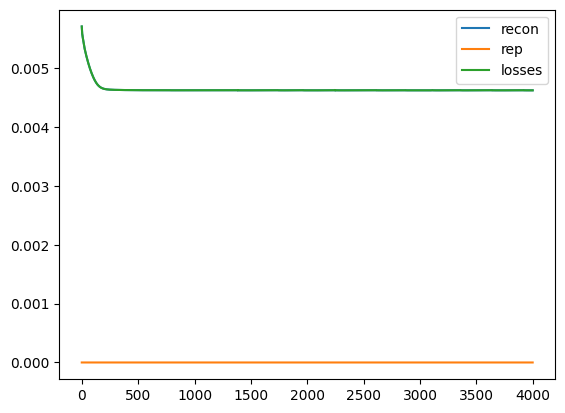

In [85]:
new_state_encoder = train_state_encoder(4000)

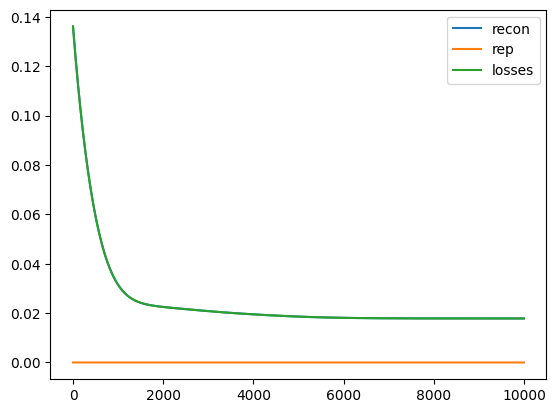

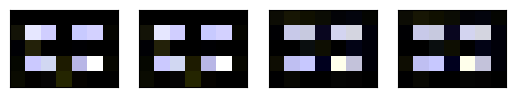

In [83]:
def train_best_encoding(n_minibatches):
    # import copy
    # new_state_encoder = copy.deepcopy(world_model.state_encoder2)
    
    # with torch.no_grad():
    #     target_state_encodings = world_model.state_encoder2(state_tensors[:-4]).squeeze(-1).squeeze(-1)
    
    # print(target_state_encodings[0])
    
    state_encodings = torch.ones((4, 8)).float().to(device)
    state_encodings.requires_grad = True
    
    opt = torch.optim.Adam([state_encodings], lr=0.001)
    recon_losses, rep_shift_penalties, losses = [], [], []
    
    
    fig, ax = plt.subplots(1, 1)
    
    for i in range(n_minibatches):
        # state_encodings = new_state_encoder(state_tensors).squeeze(-1).squeeze(-1)
        recon_state = world_model.state_decoder(torch.cat((torch.zeros_like(state_encodings), state_encodings), dim=-1).unsqueeze(-1).unsqueeze(-1))
        recon_loss = nn.functional.mse_loss(recon_state, state_tensors[-4:])
        # rep_shift_penalty = nn.functional.mse_loss(state_encodings[:-4], target_state_encodings)
        rep_shift_penalty = torch.tensor(0)
        loss = recon_loss + rep_shift_penalty
        
        recon_losses.append(recon_loss.item())
        rep_shift_penalties.append(rep_shift_penalty.item())
        losses.append(loss.item())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    ax.plot(range(n_minibatches), recon_losses, label="recon")
    ax.plot(range(n_minibatches), rep_shift_penalties, label="rep")
    ax.plot(range(n_minibatches), losses, label="losses")
    ax.legend()
    
    plt.show()
    
    new_pred_state = world_model.state_decoder(torch.cat((torch.zeros_like(state_encodings), state_encodings), dim=-1).unsqueeze(-1).unsqueeze(-1))
    
    fig, axes = plt.subplots(1, 4)

    for i in range(4):
        ax = axes[i]
        ax.imshow(np.clip(to_np(new_pred_state[i]) * 255, 0, 255).astype(int).transpose((1, 2, 0)))
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
        
    # return state_encodings

train_best_encoding(10000)

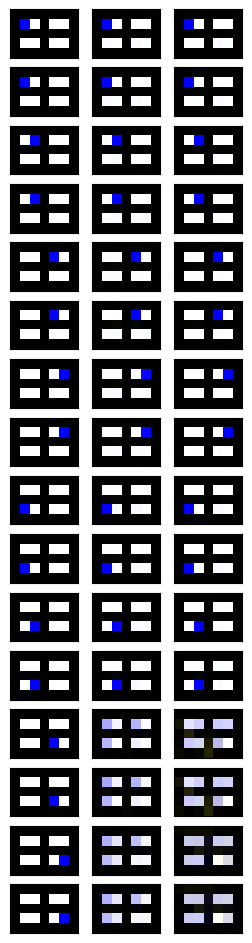

In [86]:
@torch.no_grad()
def autoencode_new(new_state_encoder):
    state_enc = world_model.state_encoder2(state_tensors)
    new_state_enc = new_state_encoder(state_tensors)
    
    recon_state = world_model.state_decoder(torch.cat((torch.zeros_like(state_enc), state_enc), dim=1))
    new_recon_state = world_model.state_decoder(torch.cat((torch.zeros_like(state_enc), new_state_enc), dim=1))

    def plot_pred_transition(ax_row, state, pred_state, new_pred_state):
        ax_row[0].imshow(state.transpose((1, 2, 0)) * 255)
        ax_row[1].imshow(np.clip(to_np(pred_state) * 255, 0, 255).astype(int).transpose((1, 2, 0)))
        ax_row[2].imshow(np.clip(to_np(new_pred_state) * 255, 0, 255).astype(int).transpose((1, 2, 0)))
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    dataset = train_dataset + test_dataset
    n_state_action_pairs = len(dataset)
    fig, axes = plt.subplots(n_state_action_pairs, 3, figsize=(3, 12))
    for i in range(n_state_action_pairs):
        state, _, _ = dataset[i]
        plot_pred_transition(axes[i], state, recon_state[i], new_recon_state[i])
    plt.show()
    
autoencode_new(new_state_encoder)

In [ ]:
new_state_encoder

In [18]:
def backprop_input(target, n_steps):
    next_state_enc = torch.ones((16, 8, 1, 1)).float().to(device)
    next_state_enc.requires_grad = True
    opt = torch.optim.Adam([next_state_enc], lr=.001)
    
    for _ in range(n_steps):
        pred_next_state = world_model.state_decoder(next_state_enc)
        loss = nn.functional.mse_loss(pred_next_state, target) + .1 * nn.functional.mse_loss(next_state_enc[group_left], next_state_enc[group_right])
        opt.zero_grad()
        loss.backward()
        opt.step()
    return to_np(next_state_enc.squeeze())

In [19]:
expected_next_state_encodings = backprop_input(next_state_tensors.detach(), n_steps=1000)

RuntimeError: Given transposed=1, weight of size [16, 8, 3, 5], expected input[16, 8, 1, 1] to have 16 channels, but got 8 channels instead

In [18]:
with np.printoptions(precision=2):
    for a, b in zip(to_np(pred_next_state_encodings), expected_next_state_encodings):
        print(a)
        print(b)
        print()

[ 2.32  3.89 -0.19  4.63 -0.16  5.08 -0.13 -0.12]
[0.39 0.77 0.24 0.69 0.23 0.42 0.31 0.29]

[ 4.41  3.   -0.15  4.68 -0.2   4.26 -0.06 -0.24]
[0.42 0.85 0.26 0.48 0.22 0.41 0.27 0.29]

[ 2.28  3.9  -0.19  4.61 -0.16  5.09 -0.13 -0.11]
[0.39 0.77 0.24 0.69 0.23 0.42 0.31 0.29]

[ 4.41  2.99 -0.16  4.66 -0.2   4.24 -0.06 -0.24]
[0.42 0.85 0.26 0.48 0.22 0.41 0.27 0.29]

[ 2.32  3.85 -0.12  4.61 -0.28  5.14 -0.15 -0.11]
[0.38 0.56 0.26 0.52 0.22 0.44 0.27 0.28]

[ 4.34  2.88 -0.19  4.83 -0.22  4.23 -0.12 -0.22]
[0.39 0.65 0.24 0.78 0.21 0.39 0.26 0.28]

[ 2.29  3.86 -0.12  4.59 -0.28  5.14 -0.15 -0.1 ]
[0.38 0.56 0.26 0.52 0.22 0.44 0.27 0.28]

[ 4.34  2.88 -0.19  4.81 -0.22  4.22 -0.13 -0.21]
[0.39 0.65 0.24 0.78 0.21 0.39 0.26 0.28]

[ 2.32  3.91 -0.09  4.63 -0.18  5.08 -0.21 -0.16]
[0.38 0.82 0.29 0.71 0.22 0.41 0.26 0.28]

[ 4.37  2.9  -0.09  4.78 -0.17  4.27 -0.06 -0.17]
[0.42 0.63 0.28 0.68 0.24 0.44 0.29 0.31]

[ 2.28  3.91 -0.08  4.62 -0.18  5.07 -0.21 -0.15]
[0.38 0.82 0.29 0.71

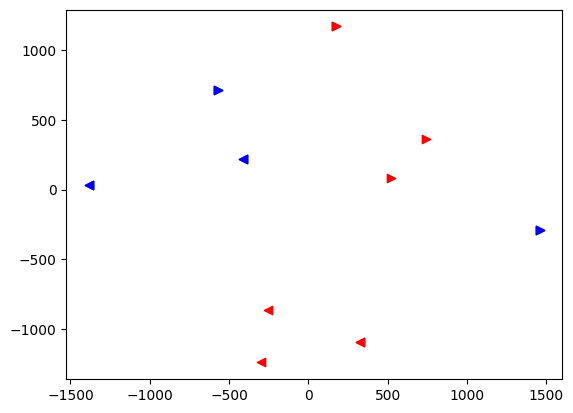

In [22]:
plot_representations(torch.from_numpy(expected_next_state_encodings))

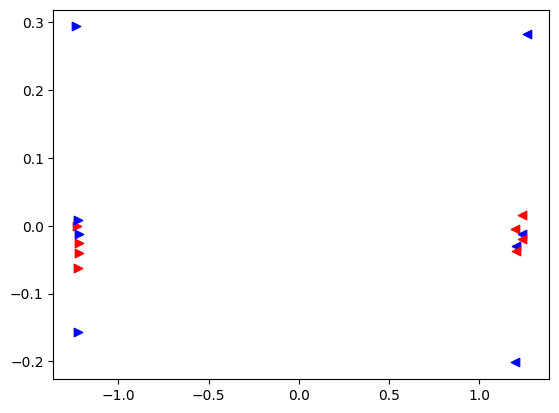

In [23]:
def plot_pca(next_state_encodings):
    next_state_representations = to_np(next_state_encodings)
    next_state_representations = sklearn.decomposition.PCA(2).fit_transform(next_state_representations)
    # colors = ["red", "blue", "black", "green"]
    colors = ["red", "blue"]
    markers = ["<", ">"]
    for s in range(8):
        for a in range(2):
            c = colors[s//2 % 2]
            m = markers[a]
            i = np.ravel_multi_index((s, a), (8, 2))
            plt.scatter(next_state_representations[i, 0], next_state_representations[i, 1], c=c, marker=m)
    plt.show()
    
plot_pca(pred_next_state_encodings)

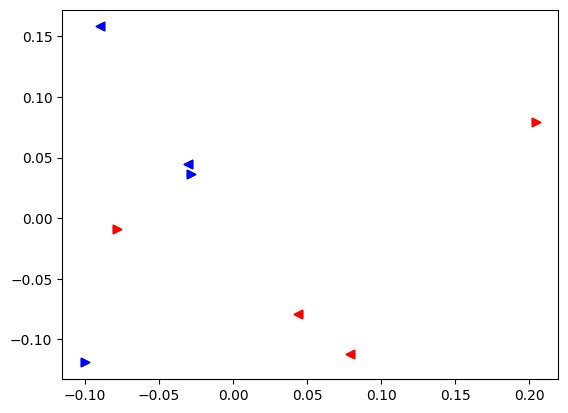

In [25]:
plot_pca(torch.from_numpy(expected_next_state_encodings))

In [27]:
with np.printoptions(2):
    print(expected_next_state_encodings[::2])

[[0.39 0.77 0.24 0.69 0.23 0.42 0.31 0.29]
 [0.39 0.77 0.24 0.69 0.23 0.42 0.31 0.29]
 [0.38 0.56 0.26 0.52 0.22 0.44 0.27 0.28]
 [0.38 0.56 0.26 0.52 0.22 0.44 0.27 0.28]
 [0.38 0.82 0.29 0.71 0.22 0.41 0.26 0.28]
 [0.38 0.82 0.29 0.71 0.22 0.41 0.26 0.28]
 [0.38 0.65 0.26 0.6  0.23 0.41 0.27 0.28]
 [0.38 0.65 0.26 0.6  0.23 0.41 0.27 0.28]]


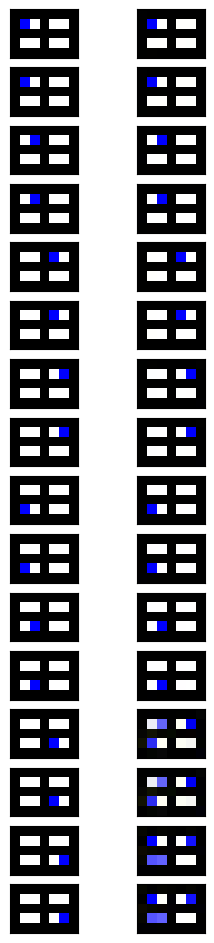

In [28]:
@torch.no_grad()
def autoencode():
    state_enc = world_model.state_encoder(state_tensors)
    pred_states = world_model.state_decoder(state_enc)

    def plot_pred_transition(ax_row, state, pred_state):
        ax_row[0].imshow(state.transpose((1, 2, 0)) * 255)
        ax_row[1].imshow(np.clip(to_np(pred_state) * 255, 0, 255).astype(int).transpose((1, 2, 0)))
        for ax in ax_row:
            ax.set_xticks([])
            ax.set_yticks([])
    
    dataset = train_dataset + test_dataset
    n_state_action_pairs = len(dataset)
    fig, axes = plt.subplots(n_state_action_pairs, 2, figsize=(3, 12))
    for i in range(n_state_action_pairs):
        state, _, _ = dataset[i]
        plot_pred_transition(axes[i], state, pred_states[i])
    plt.show()
    
autoencode()

In [54]:
from fim import flatten_params, recover_flattened, get_jac, get_FIM, get_FIM_inv, flatten_jac

In [51]:
flat_param_dict = flatten_params(world_model)

In [53]:
flat_param_dict["indices"]

[(0, 360),
 (360, 368),
 (368, 944),
 (944, 952),
 (952, 1096),
 (1096, 1112),
 (1112, 1368),
 (1368, 1384),
 (1384, 1512),
 (1512, 1520),
 (1520, 2480),
 (2480, 2488),
 (2488, 2704),
 (2704, 2707)]